## IMPORT : RAW.DATA

1.  **Create a DataFrame:** Create a Pandas DataFrame from the data

## 🧠 OS Concepts Integration: Process Scheduling, Memory Management, and File I/O

In [ ]:
import psutil
import os
import time
import multiprocessing
import mmap
import pandas as pd
import threading
import matplotlib.pyplot as plt

In [ ]:
# ✅ Plotting function for comparison
def plot_results(timings):
    labels = []
    times = []
    for method, time_taken in timings:
        labels.append(method)
        times.append(time_taken)

    plt.figure(figsize=(6, 4))
    plt.bar(labels, times, color=['skyblue', 'lightgreen'])
    plt.ylabel('Time (seconds)')
    plt.title('Read Method Performance Comparison')
    plt.savefig("performance_comparison.png")
    print("[📊] Plot saved as performance_comparison.png")

In [ ]:
# ✅ Utility: Memory and CPU usage logger
def log_memory_cpu(tag, output_queue):
    process = psutil.Process(os.getpid())
    mem_mb = process.memory_info().rss / 1024 ** 2
    cpu_percent = process.cpu_percent(interval=0.1)
    output_queue.put(f"[{tag}] Memory: {mem_mb:.2f} MB | CPU: {cpu_percent:.2f}%")

In [ ]:
# ✅ Resource monitoring (3 seconds)
def monitor_resources(output_queue, duration=3):
    process = psutil.Process(os.getpid())
    for i in range(duration):
        mem = process.memory_info().rss / 1024 ** 2
        cpu = process.cpu_percent(interval=1)
        output_queue.put(f"[Monitor {i+1}] Memory: {mem:.2f} MB | CPU: {cpu:.2f}%")

In [ ]:
# ✅ Process 1: Load CSV with pandas and monitor resources
def load_data(output_queue, timing_queue):
    try:
        monitor_thread = threading.Thread(target=monitor_resources, args=(output_queue, 3))
        monitor_thread.start()

        log_memory_cpu("Before reading CSV", output_queue)
        start = time.time()

        if not os.path.exists("raw_data.csv"):
            output_queue.put("[ERROR] raw_data.csv not found.")
            return

        df = pd.read_csv("raw_data.csv")

        elapsed = time.time() - start
        log_memory_cpu("After reading CSV", output_queue)
        output_queue.put(f"[Pandas] CSV loaded in {elapsed:.4f} seconds")
        timing_queue.put(("pandas", elapsed))

        monitor_thread.join()

    except Exception as e:
        output_queue.put(f"[ERROR] Pandas read failed: {str(e)}")

In [ ]:
# ✅ Process 2: mmap reading (full file)
def mmap_read(output_queue, timing_queue):
    try:
        start = time.time()
        if not os.path.exists("raw_data.csv"):
            output_queue.put("[ERROR] raw_data.csv not found.")
            return

        with open("raw_data.csv", 'r') as f:
            with mmap.mmap(f.fileno(), length=0, access=mmap.ACCESS_READ) as mm:
                content = mm.read()  # ✅ Read entire file content
                text = content.decode(errors='ignore')  # decode bytes to string

                output_queue.put("[mmap] Full file read successfully.")
                output_queue.put(f"[mmap] Total bytes read: {len(content)}")

        elapsed = time.time() - start
        output_queue.put(f"[mmap] Read completed in {elapsed:.4f} seconds")
        timing_queue.put(("mmap", elapsed))

    except Exception as e:
        output_queue.put(f"[ERROR] mmap read failed: {str(e)}")

In [ ]:
# ✅ Process 3: Buffered reading method
def buffered_read(output_queue, timing_queue, buffer_size=1024):
    try:
        start = time.time()
        if not os.path.exists("raw_data.csv"):
            output_queue.put("[ERROR] raw_data.csv not found.")
            return

        total_bytes = 0
        with open("raw_data.csv", 'r', buffering=buffer_size) as f:
            while True:
                chunk = f.read(buffer_size)
                if not chunk:
                    break
                total_bytes += len(chunk)

        elapsed = time.time() - start
        output_queue.put(f"[Buffered] Total bytes read: {total_bytes}")
        output_queue.put(f"[Buffered] Read completed in {elapsed:.4f} seconds")
        timing_queue.put(("buffered", elapsed))

    except Exception as e:
        output_queue.put(f"[ERROR] Buffered read failed: {str(e)}")



[PROCESS SCHEDULING] Starting subprocesses...

--- Pandas CSV Load Outputs ---
[Before reading CSV] Memory: 114.50 MB | CPU: 0.00%
[After reading CSV] Memory: 120.36 MB | CPU: 0.00%
[Pandas] CSV loaded in 0.0195 seconds
[Monitor 1] Memory: 114.50 MB | CPU: 2.00%
[Monitor 2] Memory: 120.39 MB | CPU: 0.00%
[Monitor 3] Memory: 120.39 MB | CPU: 0.00%

--- mmap File Read Outputs ---
[mmap] Full file read successfully.
[mmap] Total bytes read: 48717
[mmap] Read completed in 0.0014 seconds

--- Buffered File Read Outputs ---
[Buffered] Total bytes read: 48717
[Buffered] Read completed in 0.0004 seconds
[📊] Plot saved as performance_comparison.png

[DONE] All subprocesses completed with visualization.


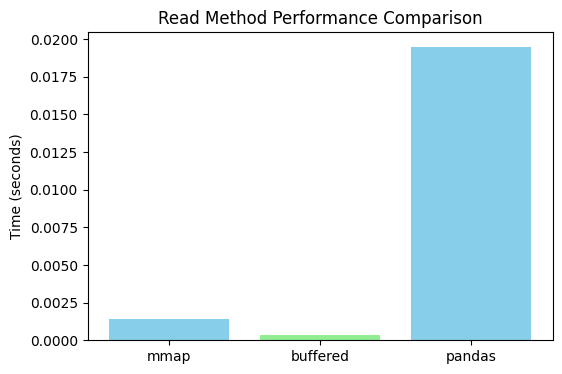

In [ ]:
# ✅ Main execution
if __name__ == '__main__':
    output_queue1 = multiprocessing.Queue()
    output_queue2 = multiprocessing.Queue()
    output_queue3 = multiprocessing.Queue()
    timing_queue = multiprocessing.Queue()

    print("\n[PROCESS SCHEDULING] Starting subprocesses...")

    p1 = multiprocessing.Process(target=load_data, args=(output_queue1, timing_queue))
    p2 = multiprocessing.Process(target=mmap_read, args=(output_queue2, timing_queue))
    p3 = multiprocessing.Process(target=buffered_read, args=(output_queue3, timing_queue))
    p1.start()
    p2.start()
    p3.start()
    p1.join()
    p2.join()
    p3.join()

    print("\n--- Pandas CSV Load Outputs ---")
    while not output_queue1.empty():
        print(output_queue1.get())

    print("\n--- mmap File Read Outputs ---")
    while not output_queue2.empty():
      print(output_queue2.get())

    print("\n--- Buffered File Read Outputs ---")
    while not output_queue3.empty():
      print(output_queue3.get())


    # Collect timings for plotting
    timings = []
    while not timing_queue.empty():
        timings.append(timing_queue.get())

    # ✅ Plot the comparison
    plot_results(timings)

    print("\n[DONE] All subprocesses completed with visualization.")


In [ ]:
import io
import pandas as pd
import os

try:
    file_path = 'raw_data.csv'

    if not os.path.exists(file_path):
        raise FileNotFoundError

    buffer_size = 1024  # You can tune this if needed
    file_content = ""

    with open(file_path, 'r', buffering=buffer_size) as f:
        while True:
            chunk = f.read(buffer_size)
            if not chunk:
                break
            file_content += chunk

    # ✅ Convert the buffered content to a DataFrame
    df = pd.read_csv(io.StringIO(file_content))

    print("CSV file loaded successfully using buffered reader and pandas!")

except FileNotFoundError:
    print("Error: 'raw_data.csv' not found. Please make sure the file is in the same directory or provide the correct path.")
    exit()


CSV file loaded successfully using buffered reader and pandas!


In [ ]:
print("\nInfo about the data types:")
print(df.info())
print("\nDescribe:")
print(df.describe())
print("\nColumns:")
print(df.columns)


Info about the data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study

### Identifying Missing Values

In [ ]:
print("Missing Values per Column:")
print(df.isnull().sum())

Missing Values per Column:
anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64


### There's no data missing values

In [ ]:
print(df.head())

   anxiety_level  self_esteem  mental_health_history  depression  headache  \
0             14           20                      0          11         2   
1             15            8                      1          15         5   
2             12           18                      1          14         2   
3             16           12                      1          15         4   
4             16           28                      0           7         2   

   blood_pressure  sleep_quality  breathing_problem  noise_level  \
0               1              2                  4            2   
1               3              1                  4            3   
2               1              2                  2            2   
3               3              1                  3            4   
4               3              5                  1            3   

   living_conditions  ...  basic_needs  academic_performance  study_load  \
0                  3  ...            2        

In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load sample data to write
df = pd.read_csv("raw_data.csv")

# ✅ Method 1: Buffered writing using open()
def write_buffered(df):
    content = df.to_csv(index=False)
    start = time.time()
    with open("output_buffered.csv", "w", buffering=1024) as f:
        f.write(content)
    return time.time() - start

# ✅ Method 2: Pandas to_csv
def write_pandas_csv(df):
    start = time.time()
    df.to_csv("output_pandas.csv", index=False)
    return time.time() - start

# ✅ Method 3: Parquet format (binary)
def write_parquet(df):
    start = time.time()
    df.to_parquet("output.parquet")
    return time.time() - start

# ✅ Run all and collect timings
timings = []
timings.append(("Buffered write", write_buffered(df)))
timings.append(("Pandas CSV", write_pandas_csv(df)))
timings.append(("Parquet format", write_parquet(df)))

# ✅ Show results
for method, t in timings:
    print(f"{method} took {t:.4f} seconds")

# ✅ Plot the comparison
labels = [x[0] for x in timings]
times = [x[1] for x in timings]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=["skyblue", "orange", "lightgreen"])
plt.ylabel("Time (seconds)")
plt.title("File Writing Method Benchmark")
plt.savefig("write_speed_comparison.png")
print("[📊] Plot saved as write_speed_comparison.png")


In [ ]:
try:
    df.to_csv('../data/processed_data.csv', index=False)
    print("CSV file saved successfully as 'processed_data.csv'!")
except Exception as e:
    print("Error: CSV file unsuccessfully saved")

CSV file saved successfully as 'processed_data.csv'!
